In [19]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

# Load the dataset
data = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Display basic info
print("First 5 rows:")
print(data.head())
print("\nData Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

First 5 rows:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon          Car      

In [20]:
# Convert Delivery_Time to binary classification (Fast/Delayed)
# Assuming deliveries under 45 minutes are "Fast" (1) and others are "Delayed" (0)
data['Delivery_Status'] = (data['Delivery_Time'] <= 45).astype(int)

# Function to extract coordinates from location strings
def extract_lat_lon(loc_str):
    lat, lon = map(float, loc_str.strip('()').split(','))
    return lat, lon

# Calculate actual distance using Haversine formula
def calculate_distance(row):
    cust_lat, cust_lon = extract_lat_lon(row['Customer_Location'])
    rest_lat, rest_lon = extract_lat_lon(row['Restaurant_Location'])
    return haversine((cust_lat, cust_lon), (rest_lat, rest_lon))

# Apply distance calculation
data['Calculated_Distance'] = data.apply(calculate_distance, axis=1)

# Display the new columns
print("\nData with new features:")
print(data[['Order_ID', 'Customer_Location', 'Restaurant_Location', 
            'Distance', 'Calculated_Distance', 'Delivery_Time', 'Delivery_Status']].head())


Data with new features:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

   Calculated_Distance  Delivery_Time  Delivery_Status  
0           775.652269          26.22                1  
1          1042.387037          62.61                0  
2           476.221364          48.43                0  
3           389.913167         111.63                0  
4           806.507000          32.38                1  


In [21]:
# Time-based features
def time_of_day(time_str):
    if time_str == 'Morning':
        return 0
    elif time_str == 'Afternoon':
        return 1
    elif time_str == 'Evening':
        return 2
    else:  # Night
        return 3

data['Time_Of_Day_Encoded'] = data['Order_Time'].apply(time_of_day)
data['Is_Rush_Hour'] = data['Order_Time'].isin(['Morning', 'Evening']).astype(int)

# Encode categorical variables
weather_mapping = {'Sunny': 0, 'Cloudy': 1, 'Rainy': 2, 'Snowy': 3}
data['Weather_Encoded'] = data['Weather_Conditions'].map(weather_mapping)

traffic_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['Traffic_Encoded'] = data['Traffic_Conditions'].map(traffic_mapping)

vehicle_mapping = {'Bicycle': 0, 'Bike': 1, 'Car': 2}
data['Vehicle_Encoded'] = data['Vehicle_Type'].map(vehicle_mapping)

priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['Priority_Encoded'] = data['Order_Priority'].map(priority_mapping)

# Select features for modeling
features = ['Calculated_Distance', 'Weather_Encoded', 'Traffic_Encoded', 
            'Delivery_Person_Experience', 'Priority_Encoded', 'Time_Of_Day_Encoded',
            'Is_Rush_Hour', 'Vehicle_Encoded', 'Restaurant_Rating', 'Customer_Rating',
            'Order_Cost', 'Tip_Amount']

target = 'Delivery_Status'

# Display engineered features
print("\nEngineered Features:")
print(data[features + [target]].head())


Engineered Features:
   Calculated_Distance  Weather_Encoded  Traffic_Encoded  \
0           775.652269                2                1   
1          1042.387037                1                1   
2           476.221364                3                1   
3           389.913167                1                0   
4           806.507000                2                2   

   Delivery_Person_Experience  Priority_Encoded  Time_Of_Day_Encoded  \
0                           4                 1                    1   
1                           8                 0                    3   
2                           9                 2                    3   
3                           2                 1                    2   
4                           6                 0                    3   

   Is_Rush_Hour  Vehicle_Encoded  Restaurant_Rating  Customer_Rating  \
0             0                2                4.1              3.0   
1             0                2        

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data into train and test sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")

# Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")


Logistic Regression Performance:
Accuracy: 0.7250
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Random Forest Performance:
Accuracy: 0.7250
Precision: 0.3333
Recall: 0.1000
F1 Score: 0.1538


Epoch 1/30, Train Loss: 0.7051, Train Acc: 0.4250, Test Loss: 0.6677, Test Acc: 0.7500
Epoch 2/30, Train Loss: 0.6479, Train Acc: 0.7250, Test Loss: 0.6123, Test Acc: 0.7500
Epoch 3/30, Train Loss: 0.5903, Train Acc: 0.7562, Test Loss: 0.5720, Test Acc: 0.7500
Epoch 4/30, Train Loss: 0.5572, Train Acc: 0.7562, Test Loss: 0.5630, Test Acc: 0.7500
Epoch 5/30, Train Loss: 0.5723, Train Acc: 0.7562, Test Loss: 0.5745, Test Acc: 0.7500
Epoch 6/30, Train Loss: 0.5509, Train Acc: 0.7562, Test Loss: 0.5717, Test Acc: 0.7500
Epoch 7/30, Train Loss: 0.5638, Train Acc: 0.7562, Test Loss: 0.5653, Test Acc: 0.7500
Epoch 8/30, Train Loss: 0.5570, Train Acc: 0.7562, Test Loss: 0.5660, Test Acc: 0.7500
Epoch 9/30, Train Loss: 0.5711, Train Acc: 0.7562, Test Loss: 0.5683, Test Acc: 0.7500
Epoch 10/30, Train Loss: 0.5421, Train Acc: 0.7562, Test Loss: 0.5712, Test Acc: 0.7500
Epoch 11/30, Train Loss: 0.5402, Train Acc: 0.7562, Test Loss: 0.5718, Test Acc: 0.7500
Epoch 12/30, Train Loss: 0.5366, Train Ac

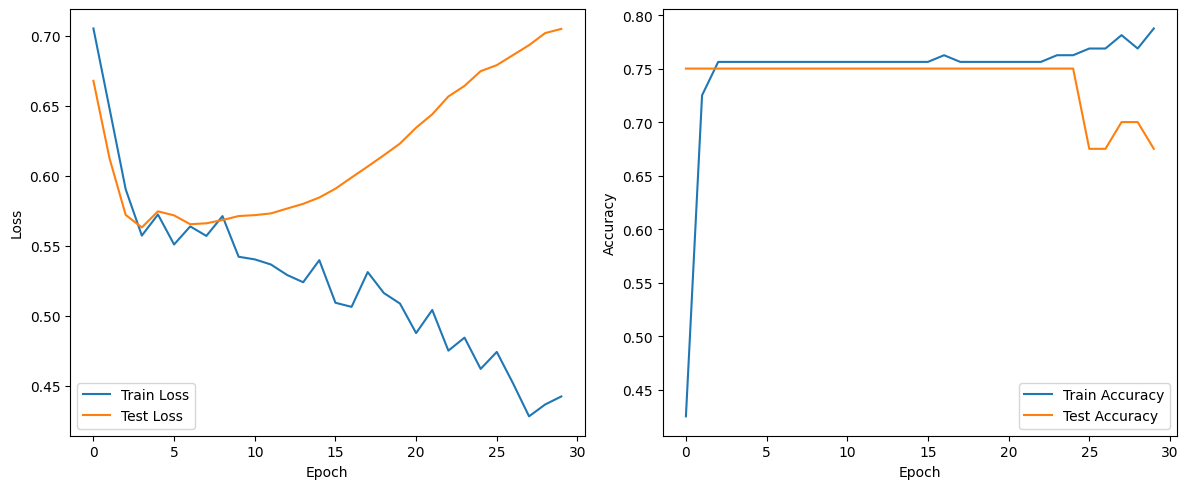

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Standardize the data for CNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create PyTorch datasets
class DeliveryDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = DeliveryDataset(X_train_scaled, y_train.values)
test_dataset = DeliveryDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        # Treat the features as a 1D "image"
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # After two pooling layers with kernel_size=2, the sequence length is divided by 4
        self.flattened_size = 32 * (input_size // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Add channel dimension (batch_size, 1, num_features)
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten with correct dimension calculation
        x = x.view(-1, self.flattened_size)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model with correct input size
input_size = X_train.shape[1]
model = CNNModel(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


CNN Performance:
Accuracy: 0.6750
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.3467


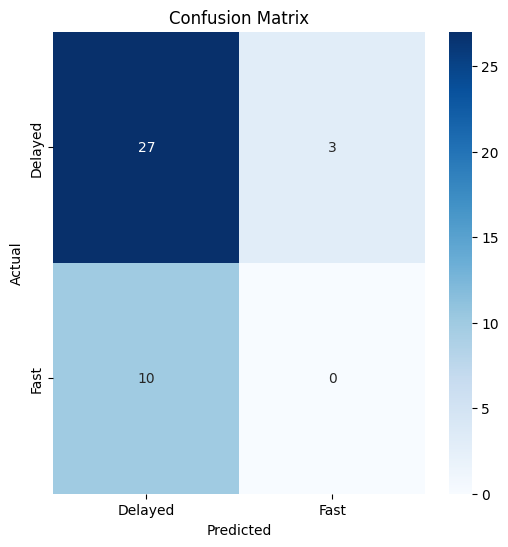

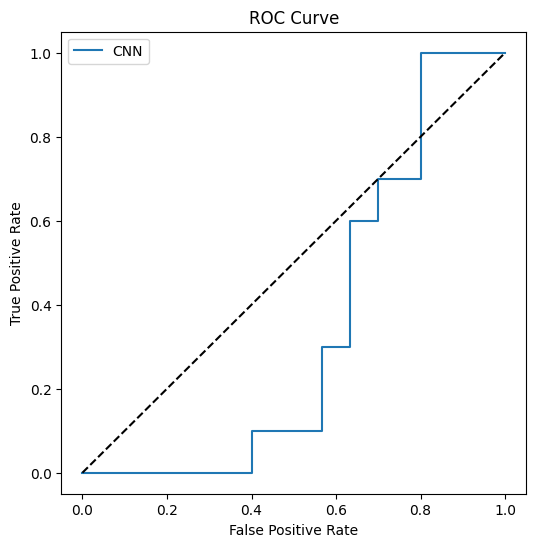

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Final evaluation on test set
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_probs.extend(torch.softmax(outputs, dim=1)[:, 1].numpy())

print("\nCNN Performance:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_true, y_probs):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'Fast'], 
            yticklabels=['Delayed', 'Fast'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='CNN')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Cross-validation for traditional models
print("\nCross-validation Results:")
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")

# Hyperparameter tuning for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(f"\nBest Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")


Cross-validation Results:
Logistic Regression - Mean Accuracy: 0.7300 (±0.0100)
Random Forest - Mean Accuracy: 0.7600 (±0.0255)

Best Random Forest Parameters:
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best CV Accuracy: 0.7375

Best Random Forest Test Accuracy: 0.7500
